In [248]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import os
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import kagglehub

# =========================
# 0. DOWNLOAD + PATHS
# =========================

path = kagglehub.dataset_download("aryarishabh/hand-gesture-recognition-dataset")
print("Kaggle dataset path:", path)

TRAIN_DIR = os.path.join(path, "train", "train")
TEST_DIR  = os.path.join(path, "test", "test")

print("Train dir:", TRAIN_DIR)
print("Test dir:", TEST_DIR)

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42


Kaggle dataset path: C:\Users\Hamza\.cache\kagglehub\datasets\aryarishabh\hand-gesture-recognition-dataset\versions\1
Train dir: C:\Users\Hamza\.cache\kagglehub\datasets\aryarishabh\hand-gesture-recognition-dataset\versions\1\train\train
Test dir: C:\Users\Hamza\.cache\kagglehub\datasets\aryarishabh\hand-gesture-recognition-dataset\versions\1\test\test


In [66]:
# TRAIN + VAL from train/train
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

# TEST from test/test
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    shuffle=False,          # important for analysis
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names   # e.g. ['0','1',...,'19']
num_classes = len(class_names)
print("Classes:", class_names)


Found 18000 files belonging to 20 classes.
Using 14400 files for training.
Found 18000 files belonging to 20 classes.
Using 3600 files for validation.
Found 6000 files belonging to 20 classes.
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


In [68]:
def ds_to_numpy(ds):
    X_list, y_list = [], []
    for images, labels in ds:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = ds_to_numpy(train_ds)
X_val,   y_val   = ds_to_numpy(val_ds)
X_test,  y_test  = ds_to_numpy(test_ds)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

# normalize to [0,1]
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0


X_train: (14400, 64, 64, 1) y_train: (14400,)
X_val: (3600, 64, 64, 1) y_val: (3600,)
X_test: (6000, 64, 64, 1) y_test: (6000,)


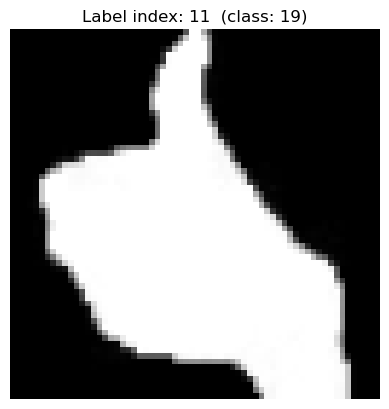

In [104]:
import matplotlib.pyplot as plt

def show_sample(X, y, class_names, index):
    img = X[index].squeeze()          # (64,64,1) → (64,64)
    label_idx = int(y[index])
    label_name = class_names[label_idx]
    
    plt.imshow(img, cmap='gray')
    plt.title(f"Label index: {label_idx}  (class: {label_name})")
    plt.axis('off')
    plt.show()

# Example:
testingimage_index = 60
show_sample(X_train, y_train, class_names, testingimage_index)


In [220]:
X_train[testingimage_index].squeeze().shape

(64, 64)

In [72]:
# Flatten for classical ML (LR, RF)
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("\n=== Training Logistic Regression ===")
lr = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    n_jobs=-1
)
lr.fit(X_train_flat, y_train)

y_val_pred_lr  = lr.predict(X_val_flat)
y_test_pred_lr = lr.predict(X_test_flat)

print("LR Val Accuracy:",  accuracy_score(y_val,  y_val_pred_lr))
print("LR Test Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("LR Confusion (test):\n", confusion_matrix(y_test, y_test_pred_lr))
print("LR Report (test):\n",
      classification_report(y_test, y_test_pred_lr, target_names=class_names))


=== Training Logistic Regression ===


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LR Val Accuracy: 1.0
LR Test Accuracy: 0.9973333333333333
LR Confusion (test):
 [[300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   6   0   0   0 294   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2   0   0   0   0   0   0   0 298   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   2   0   0   0   0   0   0 298   0   0   0   0   0   0 

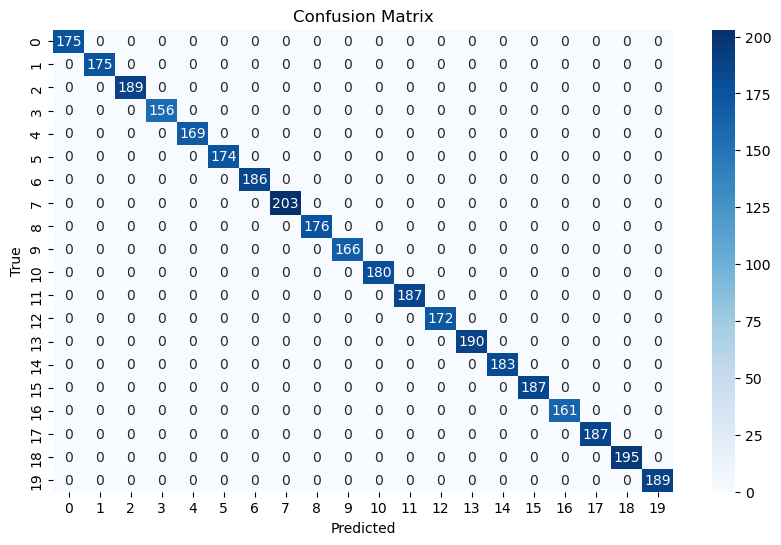

Saved confusion_matrix.png


In [250]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred_lr)

# Plot & save
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Save as image
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved confusion_matrix.png")

In [226]:
X_train[testingimage_index].reshape(1, -1).shape

(1, 4096)

In [106]:
img_flat = X_train[testingimage_index].reshape(1, -1)
print("LR prediction:", lr.predict(img_flat))
print("True label:", y_train[testingimage_index])
label_idx_testing = int(y_train[testingimage_index])
label_name = class_names[label_idx_testing]
print("Predicition:", label_name)


LR prediction: [11]
True label: 11
Predicition: 19


flat shape: (1, 4096)


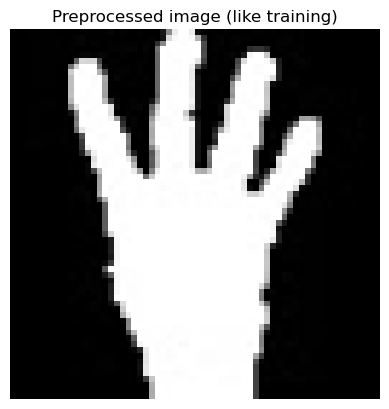

LR prediction: 14
Predicition: 4


In [242]:


IMG_SIZE = (64, 64)
def preprocess_like_training(img_path):
    # 1) open + convert to grayscale (1 channel)
    img = Image.open(img_path).convert("L")

    # 2) resize to 64x64 like dataset
    img = img.resize(IMG_SIZE)

    # 3) to numpy + normalize
    arr = np.array(img).astype("float32") / 255.0      # shape (64, 64)

    # 4) flatten to 4096 features
    flat = arr.reshape(1, -1)                          # shape (1, 4096)

    customepredict = lr.predict(flat)[0];
    labelName = class_names[customepredict]

    
    return flat, arr, labelName, customepredict

# --------- use it ----------
image_path = r"E:\learning\SMIT-AI-DTS\Hackathon\train_hand.jpg"

flat, arr,labelName,customepredict = preprocess_like_training(image_path)
print("flat shape:", flat.shape)      # should be (1, 4096)

plt.imshow(arr, cmap="gray")
plt.title("Preprocessed image (like training)")
plt.axis("off")
plt.show()

# label_name = class_names[customepredict]
# customepredict = lr.predict(flat)[0];
print("LR prediction:", customepredict)
print("Predicition:", labelName)

In [244]:
import joblib

In [246]:
# Create folder if not exists
os.makedirs("models", exist_ok=True)

# Save Logistic Regression
joblib.dump(lr, "models/logistic_regression.pkl")
print("🎉 Models saved successfully!")

🎉 Models saved successfully!
